# ProtEx: A PROTein EXtension Tool

The ultimate goal of this project is to be able to detect selenoproteins in databases which have been incorrectly truncated at the first instance of a Sec codon, which shares the same code (AUG) as the canonical stop codon. For this task, we are planning to apply the pre-trained ESM transformer.

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
# Fixing some of the issues I'm having with importing modules. 
import sys
sys.path.append('/home/prichter/Documents/protex/src/')

from src.dataset import *
from src.dataset import SequenceDataset
from src.esm import ESMClassifier, esm_train, esm_test
from src.logreg import LogisticRegressionClassifier, logreg_train, logreg_test
import scipy.stats as stats
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt


2023-06-05 00:23:38.517424: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-05 00:23:38.548441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 00:23:38.979318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data and preprocessing

All amino acid sequences were obtained from the UniProt database. The data is in FASTA format for compatibility with the CD-Hit sequence clustering tool -- I wrote additional functions to read FASTA files into `pandas.DataFrame`s, and vice versa. The datasets used, along with descriptions, are given below.
1. `./data/sec.fasta` All peptide sequences tagged in the UniProt database as containing a selenocysteine residue (there are about 20,000). All sequences have been truncated at the first selenocysteine. 
2. `./data/short.fasta` This dataset serves as true positive instances of short proteins which are *not* incorrectly truncated. This file was generated by using a Gaussian KDE to approximate a length distribution of truncated selenoproteins (in `sec_trunc.fasta`), sampling from the distribution, and downloading sequences from UniProt which match the length. This dataset is of size __. 
3. `./data/all.fasta` A combination of `sec_trunc.fasta` and `short.fasta`. Generated using `cat sec.fasta short.fasta >> all.fasta`.

In [4]:
# Using this function already assumes that the selenoprotein data has been downloaded from UniProt.
# This function overwrites the original UniProt file with the truncated sequences. 
truncate_selenoproteins('/home/prichter/Documents/protex/data/sec.fasta')

In [ ]:
# Read the newly-truncated selenoproteins sequences into a DataFrame.
sec_data = fasta_to_df('/home/prichter/Documents/protex/data/sec.fasta')
# Use KDE to generate a distribution based on the lengths of the truncated selenoproteins. 
lengths = sec_data['seq'].apply(len).to_numpy()
dist = stats.gaussian_kde(lengths)

# When I first attempted this, the dataset was extremely unbalanced... way more selenoproteins. 
download_short_proteins(dist, '/home/prichter/Documents/protex/short.fasta')



### Generating train and test data

The The CD-Hit protein clustering tool was used to organize the sequences contained in `all.fasta` into clusters with 80 percent similarity. This was done using the command `cd-hit -i all.fasta -o all -n 5 -c 0.8`. Clustering the sequences, and organizing the training and testing sets such that no cluster spans the two, helps to ensure that the test accuracy captures whether or not the model is generalizing (similar to the approach [here](https://www.biorxiv.org/content/10.1101/626507v4.full)). 

In [ ]:
# Load in the clustering and sequence information. 
clstr_data = clstr_to_df('/home/prichter/Documents/protex/data/all.clstr')
fasta_data = fasta_to_df('/home/prichter/Documents/protex/data/all.fasta')

data = clstr_data.merge(fasta_data, how='inner', on='id') # Need to combine the two DataFrames according to the ID column, using intersection of keys from both frames.
data = data.drop_duplicates(subset=['id']) # Make sure there are no duplicates (I was running into some issues with this)

Using a greedy partitioning algorithm, I split the combined dataset into a train and test set (with a roughly 75%/25% train/test split). This partitioning approach ensures that no cluster group spans both train and test datasets, for the reasons mentioned above. 

In [ ]:
train_data, test_data = train_test_split(data, train_size=0.75, test_size=0.25)

# Confirm that the split sizes are correct. 
train_size = int(len(train_data) / len(data) * 100)
test_size = int(len(test_data) / len(data) * 100)

print(f'The training dataset makes up {train_size} percent of the total data.')
print(f'The testing dataset makes up {test_size} percent of the total data.')

# Confirm that there is no cluster overlap. 
train_clusters = set(train_data['cluster'])
test_clusters = set(test_data['cluster'])
assert len(train_clusters) + len(test_clusters) == len(train_clusters.union(test_clusters))

After generating the train and test datasets, I saved the data to CSV files to avoid having to re-run cells more than I need to. These files are also stored in the data directory, and contain the amino acid sequences, unique identifiers, and cluster number.

In [ ]:
train_data.to_csv('/home/prichter/Documents/protex/data/train.csv', columns=['seq', 'id', 'cluster'])
test_data.to_csv('/home/prichter/Documents/protex/data/test.csv', columns=['seq', 'id', 'cluster'])


## Sequence classification

This part of the project is *very* incomplete as of now. Eventually, I will try each of these classification techniques, and compare. My priority right now is to do the bag-of-words benchline using a simple `torch.Embedding` layer. 

### Using ESM

This portion of code is mostly complete, although I am thinking about making some stylistic changes (e.g. moving the label and data-loading functions outside of the classifier, just so that's more visible in the code, and probably getting rid of some code repetition)

In [7]:
train_data = SequenceDataset(pd.read_csv('/home/prichter/Documents/protex/data/train.csv'))
test_data = SequenceDataset(pd.read_csv('/home/prichter/Documents/protex/data/test.csv'))

In [2]:

# from src.esm import ESMClassifier, esm_train, esm_test
# model_esm = ESMClassifier()
model_esm.summary()

+---------------------------------------------------------+------------+-------+
|                           name                          | num_params | fixed |
+---------------------------------------------------------+------------+-------+
|       model.esm.embeddings.word_embeddings.weight       |   10560    |  True |
|     model.esm.embeddings.position_embeddings.weight     |   328320   |  True |
|  model.esm.encoder.layer.0.attention.self.query.weight  |   102400   |  True |
|   model.esm.encoder.layer.0.attention.self.query.bias   |    320     |  True |
|   model.esm.encoder.layer.0.attention.self.key.weight   |   102400   |  True |
|    model.esm.encoder.layer.0.attention.self.key.bias    |    320     |  True |
|  model.esm.encoder.layer.0.attention.self.value.weight  |   102400   |  True |
|   model.esm.encoder.layer.0.attention.self.value.bias   |    320     |  True |
| model.esm.encoder.layer.0.attention.output.dense.weight |   102400   |  True |
|  model.esm.encoder.layer.0

In [ ]:
losses_v1 = esm_train(model_v1, train_data, test_data=test_data, batch_size=5, n_epochs=500)
torch.save(model_v1, 'model_v1.pickle')

In [26]:
loss, accuracy = esm_test(model_v1, test_data)

Calculating batch loss...: 100%|██████████| 9473/9473 [59:58<00:00,  2.63it/s]  


In [27]:
print(loss, accuracy)

tensor(0.6891) tensor(0.6180)


In [ ]:
losses_v2 = esm_train(model_v2, train_data, batch_size=5, n_epochs=5)
torch.save(model_v2, 'model_v2.pickle')

In [7]:
model_v3 = LogisticRegressionClassifier()
losses_v3 = logreg_train(model_v3, train_data, test_data=test_data, batch_size=32, n_epochs=500)

Training classifier...: 100%|██████████| 500/500 [33:04<00:00,  3.97s/it]


In [9]:

print(losses_v3)

{'train': [0.6667279601097107, 0.6419915556907654, 0.5727124810218811, 0.4285380244255066, 0.5395123362541199, 0.5880600214004517, 0.7747247815132141, 0.5858015418052673, 0.5920120477676392, 0.5998672246932983, 0.5498825311660767, 0.6075701713562012, 0.5122136473655701, 0.5983391404151917, 0.5306974053382874, 0.5551385283470154, 0.5715444087982178, 0.5292672514915466, 0.5799028277397156, 0.5127911567687988, 0.5606609582901001, 0.6257923245429993, 0.6363469958305359, 0.5631943941116333, 0.5928552150726318, 0.4396148920059204, 0.6010108590126038, 0.5016670227050781, 0.5400537252426147, 0.512998640537262, 0.5176847577095032, 0.4421941936016083, 0.5648357272148132, 0.5012747049331665, 0.5599599480628967, 0.38161998987197876, 0.48697686195373535, 0.5422052145004272, 0.43053629994392395, 0.9045471549034119, 0.544015645980835, 0.657130241394043, 0.4075843393802643, 0.6113972067832947, 0.6037107110023499, 0.5307761430740356, 0.6334934830665588, 0.7637499570846558, 0.5263559818267822, 0.6376473

<Axes: >

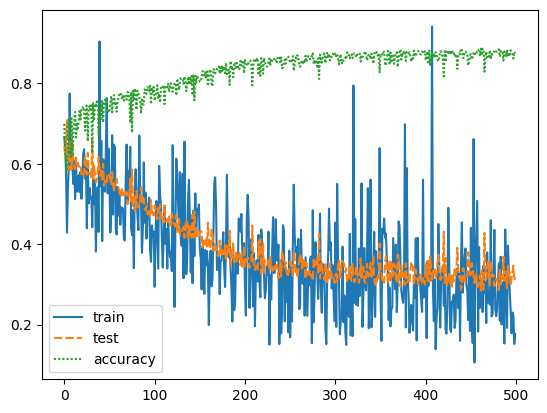

In [8]:

sns.lineplot(pd.DataFrame(losses_v3))

In [10]:
torch.save(model_v3, 'model_v3.pickle')

### Using "bag-of-words" benchmark
`#TODO`

### Using LSTM
`#TODO`

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('facebook/esm2_t6_8M_UR50D')
encoding = tokenizer([['MPSMSRRQFLKVTGTTLVGSSLALMGFAPGIALAEVRQYKLTRATETRNTCTYCSVACGI', 'FAPGIALAEVRQYKLTRATETRNTCTYCSVACGI']], return_tensors='pt', padding=True, truncation=True)

In [ ]:
encoding